### Imports

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import itertools
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm

### Numerical solver

In [50]:
# Single vaccine: effective only for menC

def ODE(t, y, params):
    nu, betaB, betaC, gammaB, gammaC, epsilon, omega, kappa, a, m = params 
    S, B, C, SV, BV, CV = y

    lambdaB = betaB * (B + BV)
    lambdaC = betaC * (C + a * CV) # reduced transmission due to vaccination
    
    dSdt  = nu - (lambdaB + lambdaC + epsilon - nu) * S + gammaB * B + gammaC * C + omega * SV
    dBdt  = - (gammaB + epsilon + nu) * B + lambdaB * S + omega * BV
    dCdt  = - (gammaC + epsilon + nu) * C + lambdaC * S + omega * CV
    dSVdt = - (lambdaB + (1 - kappa) * lambdaC + omega + nu) * SV + gammaB * BV + gammaC * CV + epsilon * m * C + epsilon * S 
    dBVdt = - (gammaB + omega + nu) * BV + lambdaB * SV + epsilon * B
    dCVdt = - (gammaC + omega + nu) * CV + (1 - kappa) * lambdaC * SV + epsilon * (1 - m) * C

    dydt = [dSdt, dBdt, dCdt, dSVdt, dBVdt, dCVdt]
    return dydt

In [51]:
nu = 0          # births (and total deaths)
betaB = 0.31    # contact rate to B: range = [0.001, ... , 1, ...] days^-1
betaC = 0.31    # contact rate to C
gammaB = 0.3    # recovery rate from B: proportion per day; infection duration = gamma^-1, range = [14, ... , 360, 420] days = [2 weeks, ... , 1 year, 14 months] 
gammaC = 0.3    # recovery rate from C
epsilon = 0     # effective vaccination rate (only menC): proportion per day (if per year, 75% is covered -> 0.75/365), range = [0.2/365, ... , 1/365]
omega = 0       # vaccine waning rate: protection duration = omega^-1, range = [30, ... , 3650] days = [1 month, ... , 10 years]
kappa = 0       # vaccine immunity to menC: probability, range = [0,1]
a = 1           # ability to tramsit infection by vaccinated and infected individuals (1 = no reduced infection transmission): probability, range = [0,1]
m = 0           # proportion of infected who lose carriage after vaccination: probability, range = [0,1]

params = [nu, betaB, betaC, gammaB, gammaC, epsilon, omega, kappa, a, m]

t_init = 0
t_fin = 100

S_init = 0.7
B_init = 0.1
C_init = 0.2
SV_init = 0
BV_init = 0
CV_init = 0
init_values = [S_init, B_init, C_init, SV_init, BV_init, CV_init]

sol = solve_ivp(ODE, [t_init, t_fin], init_values, args=[params])
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.823e-01  2.005e+00  9.828e+00  1.984e+01
             3.548e+01  5.876e+01  9.367e+01  1.000e+02]
        y: [[ 7.000e-01  7.045e-01 ...  9.502e-01  9.518e-01]
            [ 1.000e-01  9.851e-02 ...  1.659e-02  1.605e-02]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 50
     njev: 0
      nlu: 0

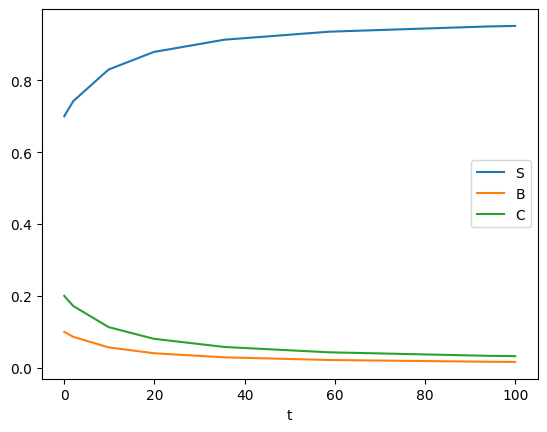

In [52]:
t = sol.t
y = sol.y

assert np.allclose(y.sum(axis=0), 1)
S, B, C, SV, BV, CV = y

plt.plot(t, S, label='S')
plt.plot(t, B, label='B')
plt.plot(t, C, label='C')
# plt.plot(t, SV, label='SV')
# plt.plot(t, BV, label='BV')
# plt.plot(t, CV, label='CV')
# plt.plot(t, B + BV, label='All B')
# plt.plot(t, C + CV, label='All C')
plt.xlabel('t')
plt.legend()
# plt.yscale('log')
plt.show()

# Explore effect of varying parameters on ODE equilibrium 

### 1. No births and (natural) deaths

##### a. No vaccine, one strain (B): SIS type model. 

Changing betaB only varies the speed at which endemic equilibrium is reached. Explore varying betaB and gammaB.


betaB values: [0.01       0.03162278 0.1        0.31622777 1.        ]
gammaB values: [0.01       0.03162278 0.1        0.31622777 1.        ]


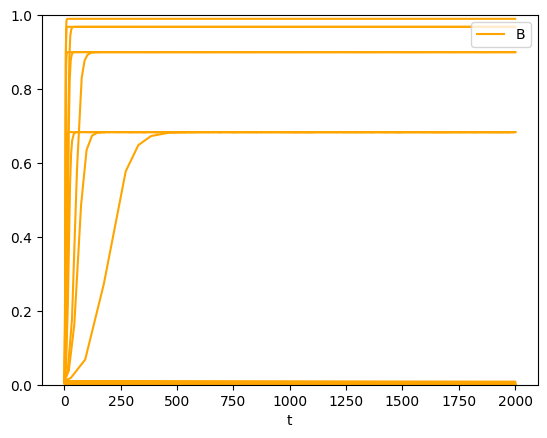

In [122]:
# Exponents
low_betaB = -2
high_betaB = 0
step_betaB = 0.4
points_betaB = int((high_betaB - low_betaB + step_betaB) / step_betaB)
betaB_exp_list = np.linspace(low_betaB, high_betaB, points_betaB)

low_gammaB = -2
high_gammaB = 0
step_gammaB = 0.4
points_gammaB = int((high_gammaB - low_gammaB + step_gammaB) / step_gammaB)
gammaB_exp_list = np.linspace(low_gammaB, high_gammaB, points_gammaB)

nu = 0          # births (and total deaths)
betaB_list = 10 ** betaB_exp_list     # contact rate to B
betaC = 0       # contact rate to C
gammaB_list = 10 ** gammaB_exp_list # recovery rate from B
gammaC = 0      # recovery rate from C
epsilon = 0     # effective vaccination rate (only menC)
omega = 0       # vaccine waning rate
kappa = 0       # vaccine immunity to menC
a = 1           # ability to tramsit infection by vaccinated and infected individuals (1 = no reduced infection transmission)
m = 0           # proportion of infected who lose carriage after vaccination

print(f'betaB values: {betaB_list}')
print(f'gammaB values: {gammaB_list}')

t_init = 0
t_fin = 2000

S_init = 0.99
B_init = 0.01
C_init = 0
SV_init = 0
BV_init = 0
CV_init = 0
init_values = [S_init, B_init, C_init, SV_init, BV_init, CV_init]

compartments = ['B']
n = len(compartments)
equilibrium = np.zeros((len(betaB_list), len(gammaB_list), n))
for i, (betaB, gammaB) in enumerate(itertools.product(betaB_list, gammaB_list)):
    params = [nu, betaB, betaC, gammaB, gammaC, epsilon, omega, kappa, a, m]
    sol = solve_ivp(
        ODE, 
        [t_init,t_fin], 
        init_values, 
        args=[params])
    t = sol.t
    y = sol.y

    S, B, _, _, _, _ = y
    row = i // len(gammaB_list)
    col = i % len(gammaB_list)
    equilibrium[row, col] = np.array([B[-1]])

    plt.plot(t, B, label='B', color='orange')
    plt.xlabel('t')
    plt.ylim(0,1)

custom_lines = [
    Line2D([0], [0], color='orange'),
]
plt.legend(custom_lines, compartments, loc='upper right')
plt.show()

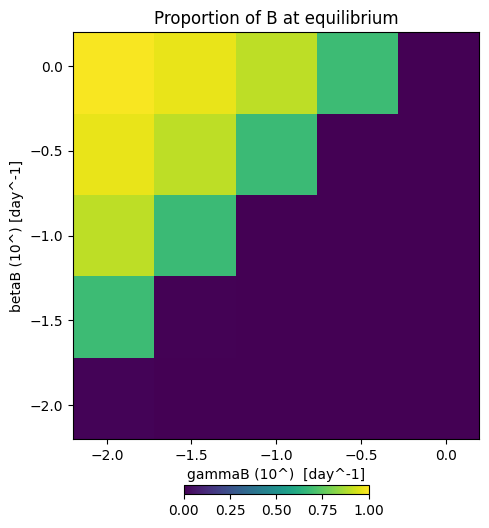

In [124]:
width = 6
fig, ax = plt.subplots(1, n, figsize=(n*width,width))

im = ax.imshow(
    equilibrium[:,:],
    cmap='viridis', 
    norm=plt.Normalize(vmin=0,vmax=1),
    # norm = LogNorm(vmin=1e-1, vmax=1), 
    extent=[gammaB_exp_list.min() - step_gammaB / 2,
            gammaB_exp_list.max() + step_gammaB / 2,
            betaB_exp_list.min() - step_betaB / 2,
            betaB_exp_list.max() + step_betaB / 2],
    origin='lower'
    )
ax.set_xlabel('gammaB (10^)  [day^-1]')
ax.set_ylabel('betaB (10^) [day^-1]')
ax.set_xticks(gammaB_exp_list)
ax.set_yticks(betaB_exp_list)
ax.set_title(f'Proportion of {compartments[0]} at equilibrium')
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)
plt.show()

##### b. No vaccine, two strains: SIS type model with competition

Equilibrium proportions depend on initial values (?) and relative contact rates of the two strains. When is there coexistence? If recovery rates are equal, only when the contact rates are equal greater than the recovery rates. In general, gamma/beta must be equal for the two strains, in order for them to coexist.


betaB values:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
betaC values:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


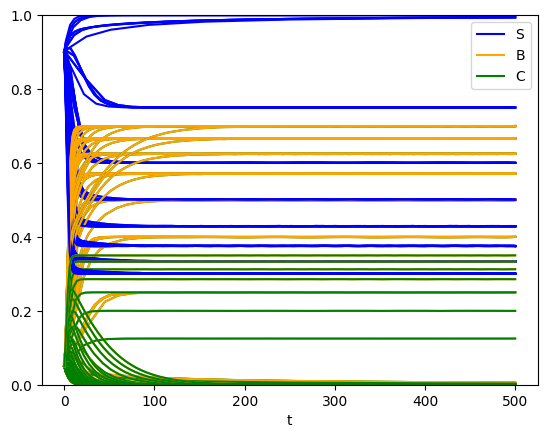

In [127]:
low_betaB = 0.1
high_betaB = 1
step_betaB = 0.1
points_betaB = round((high_betaB - low_betaB) / step_betaB) + 1

low_betaC = 0.1
high_betaC = 1
step_betaC = 0.1
points_betaC = round((high_betaC - low_betaC) / step_betaC) + 1

# # Exponents
# low_betaB = -3
# high_betaB = 0
# step_betaB = 0.4
# points_betaB = int((high_betaB - low_betaB + step_betaB) / step_betaB)
# betaB_exp_list = np.linspace(low_betaB, high_betaB, points_betaB)

# low_betaC = -3
# high_betaC = 0
# step_betaC = 0.4
# points_betaC = int((high_betaC - low_betaC + step_betaC) / step_betaC)
# betaC_exp_list = np.linspace(low_betaC, high_betaC, points_betaC)

nu = 0          # births (and total deaths)
betaB_list = np.linspace(low_betaB, high_betaB, points_betaB)     # contact rate to B
betaC_list = np.linspace(low_betaC, high_betaC, points_betaC)     # contact rate to C
# betaB_list = 10 ** betaB_exp_list     # contact rate to B
# betaC_list = 10 ** betaC_exp_list     # contact rate to C
gammaB = 0.3    # recovery rate from B
gammaC = 0.3    # recovery rate from C
epsilon = 0     # effective vaccination rate (only menC)
omega = 0       # vaccine waning rate
kappa = 0       # vaccine immunity to menC
a = 1           # ability to tramsit infection by vaccinated and infected individuals (1 = no reduced infection transmission)
m = 0           # proportion of infected who lose carriage after vaccination

print('betaB values: ', betaB_list)
print('betaC values: ', betaC_list)

t_init = 0
t_fin = 500

S_init = 0.9
B_init = 0.05
C_init = 0.05
SV_init = 0
BV_init = 0
CV_init = 0
init_values = [S_init, B_init, C_init, SV_init, BV_init, CV_init]

compartments = ['S', 'B', 'C']
n = len(compartments)
equilibrium = np.zeros((len(betaB_list), len(betaC_list), n))

for i, (betaB, betaC) in enumerate(list(itertools.product(betaB_list, betaC_list))):
    params = [nu, betaB, betaC, gammaB, gammaC, epsilon, omega, kappa, a, m]
    sol = solve_ivp(
        ODE, 
        [t_init,t_fin], 
        init_values, 
        args=[params])
    t = sol.t
    y = sol.y

    S, B, C, _, _, _ = y

    row = i // len(betaC_list)
    col = i % len(betaC_list)
    equilibrium[row, col] = np.array([S[-1], B[-1], C[-1]])

    # if np.allclose(betaB, gammaB) and np.allclose(betaC, gammaC):
    plt.plot(t, S, label='S', color='blue')
    plt.plot(t, B, label='B', color='orange')
    plt.plot(t, C, label='C', color='green')
    plt.xlabel('t')
    plt.ylim(0,1)

custom_lines = [
    Line2D([0], [0], color='blue'),
    Line2D([0], [0], color='orange'),
    Line2D([0], [0], color='green')
]
plt.legend(custom_lines, compartments, loc='upper right')
plt.show()

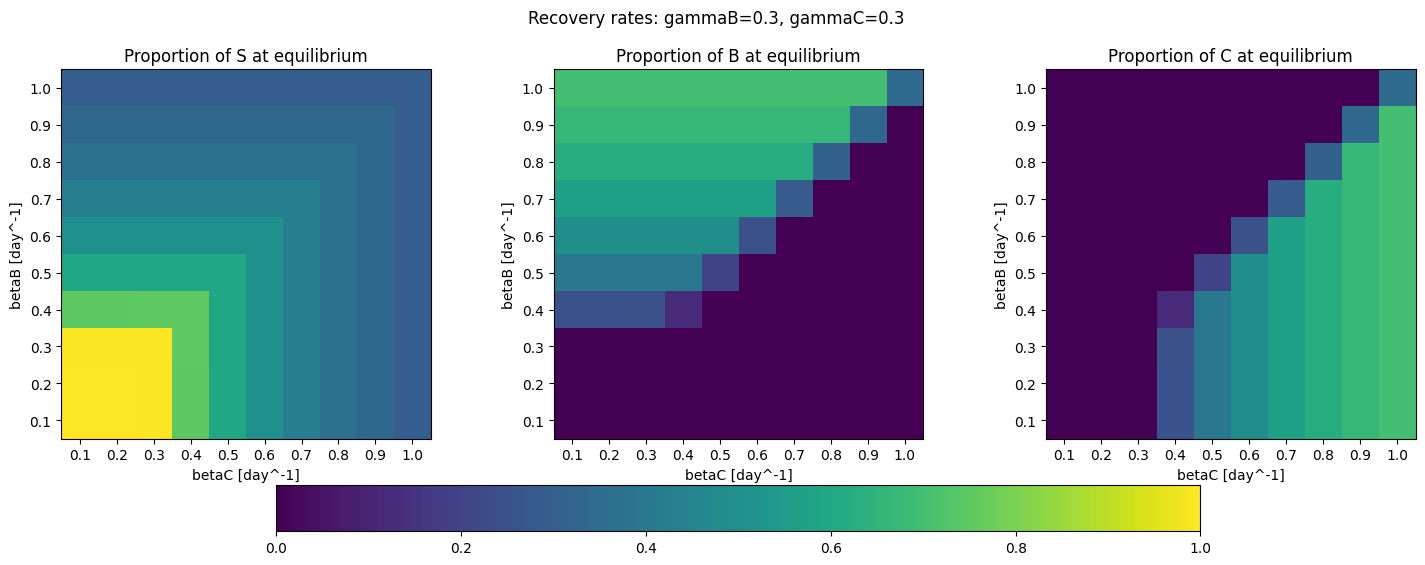

In [128]:
width = 6
fig, ax = plt.subplots(1, n, figsize=(n*width,width))
images = []
for i in range(n):
    images.append(ax[i].imshow(
        equilibrium[:,:,i],
        cmap='viridis', 
        norm=plt.Normalize(vmin=0,vmax=1), 
        extent=[low_betaC - step_betaC/2,
                high_betaC + step_betaC/2,
                low_betaB - step_betaB/2,
                high_betaB + step_betaB/2],
        # extent=[betaC_exp_list.min() - step_betaC / 2,
        #     betaC_exp_list.max() + step_betaC / 2,
        #     betaB_exp_list.min() - step_betaB / 2,
        #     betaB_exp_list.max() + step_betaB / 2],
        origin='lower'
        ))
    ax[i].set_xlabel('betaC [day^-1]')
    ax[i].set_ylabel('betaB [day^-1]')
    ax[i].set_xticks(betaC_list)
    ax[i].set_yticks(betaB_list)
    # ax[i].set_xlabel('betaC (10^) [day^-1]')
    # ax[i].set_ylabel('betaB (10^) [day^-1]')
    # ax[i].set_xticks(betaC_exp_list)
    # ax[i].set_yticks(betaB_exp_list)
    ax[i].set_title(f'Proportion of {compartments[i]} at equilibrium')
fig.suptitle(f'Recovery rates: gammaB={gammaB}, gammaC={gammaC}')
cbar = fig.colorbar(images[0], ax=ax, orientation='horizontal', fraction=0.1, pad=0.1)
plt.show()

##### c. Vaccine included: just one strain (vaccine is effective on menC)




epsilon values:  [0.00027397 0.00054795 0.00082192 0.00109589 0.00136986 0.00164384
 0.00191781 0.00219178 0.00246575 0.00273973]
omega values:  [0.00027397 0.00054795 0.00082192 0.00109589 0.00136986 0.00164384
 0.00191781 0.00219178 0.00246575 0.00273973]


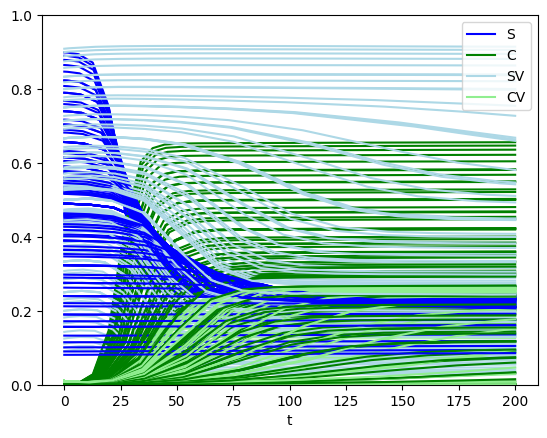

In [130]:
low_epsilon = 1 / 10 # year^-1
high_epsilon = 1
step_epsilon = 1 / 10
points_epsilon = round((high_epsilon - low_epsilon) / step_epsilon) + 1

low_omega = 1 / 10
high_omega = 1
step_omega = 1 / 10
points_omega = round((high_omega - low_omega) / step_omega) + 1

nu = 0          # births (and total deaths)
betaB = 0       # contact rate to B
betaC = 0.4     # contact rate to C
gammaB = 0      # recovery rate from B
gammaC = 0.1    # recovery rate from C
epsilon_list = np.linspace(low_epsilon, high_epsilon, points_epsilon) / 365 # effective vaccination rate (only menC): day^-1
omega_list = np.linspace(low_omega, high_omega, points_omega) / 365 # vaccine waning rate: day^-1
kappa = 0.1     # vaccine immunity to menC
a = 0.1         # ability to tramsit infection by vaccinated and infected individuals (1 = no reduced infection transmission)
m = 0           # proportion of infected who lose carriage after vaccination

print('epsilon values: ', epsilon_list)
print('omega values: ', omega_list)

t_init = 0
t_fin = 200

# S_init = 1
# B_init = 0
# C_init = 0
# SV_init = 0
# BV_init = 0
# CV_init = 0
# init_values = [S_init, B_init, C_init, SV_init, BV_init, CV_init]

compartments = ['S', 'C', 'SV', 'CV']
n = len(compartments)
equilibrium = np.zeros((len(epsilon_list), len(omega_list), n))

for i, (epsilon, omega) in enumerate(itertools.product(epsilon_list, omega_list)):
    params = [nu, betaB, betaC, gammaB, gammaC, epsilon, omega, kappa, a, m]
    
    S_init = omega / (omega + epsilon) - 0.01
    B_init = 0
    C_init = 0
    SV_init = epsilon / (omega + epsilon)
    BV_init = 0
    CV_init = 0.01
    init_values = [S_init, B_init, C_init, SV_init, BV_init, CV_init]

    sol = solve_ivp(
        ODE, 
        [t_init,t_fin], 
        init_values, 
        args=[params])
    t = sol.t
    y = sol.y

    S, _, C, SV, _, CV = y
    row = i // len(omega_list)
    col = i % len(omega_list)
    equilibrium[row, col] = np.array([S[-1], C[-1], SV[-1], CV[-1]])

    plt.plot(t, S, label='S', color='blue')
    plt.plot(t, C, label='C', color='green')
    plt.plot(t, SV, label='SV', color='lightblue')
    plt.plot(t, CV, label='CV', color='lightgreen')
    # plt.plot(t, S+SV, label='All S', color='darkblue')
    # plt.plot(t, C+CV, label='All C', color='darkgreen')

custom_lines = [
    Line2D([0], [0], color='blue'),
    Line2D([0], [0], color='green'),
    Line2D([0], [0], color='lightblue'),
    Line2D([0], [0], color='lightgreen'),
]

plt.xlabel('t')
plt.ylim(0,1)
plt.legend(custom_lines, compartments, loc='upper right')
plt.show()

# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# for i in range(len(compartments)):
#     ax.plot(epsilon_list, equilibrium[:,i], label=compartments[i])
# ax.set_xlabel('epsilon')
# ax.set_ylabel('Equilibrium values')
# ax.set_title('')
# ax.legend()
# plt.show()

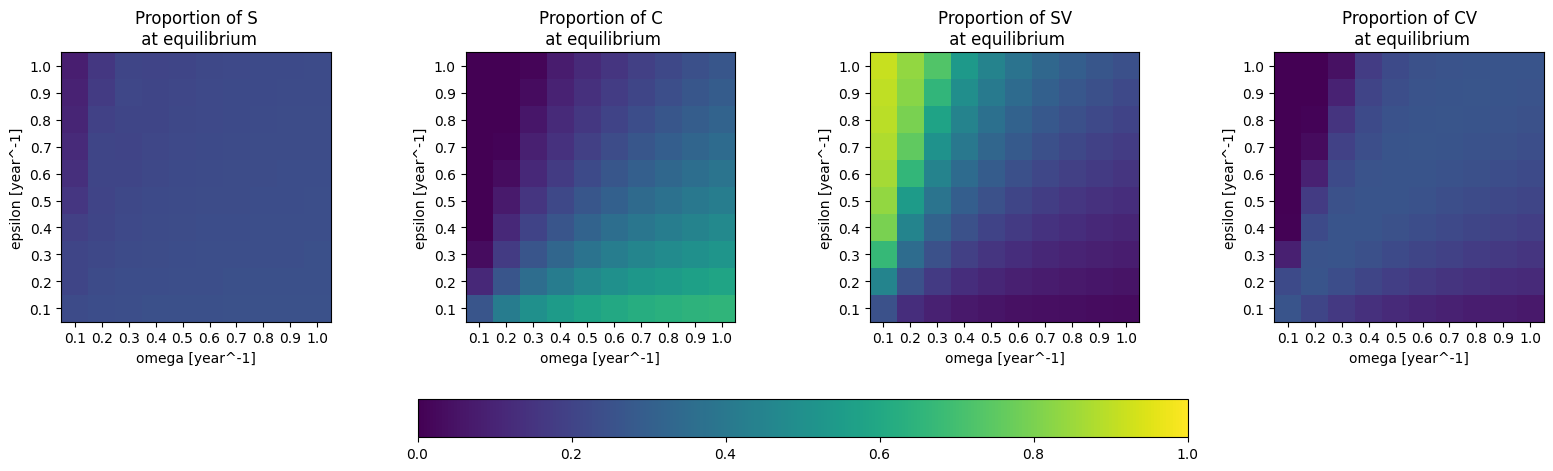

In [132]:
n = len(compartments)
width = 5
fig, ax = plt.subplots(1, n, figsize=(n*width,width))
images = []
for i in range(n):
    images.append(ax[i].imshow(
        equilibrium[:,:,i],
        cmap='viridis', 
        norm=plt.Normalize(vmin=0,vmax=1), 
        extent=[low_omega-step_omega/2,
                high_omega+step_omega/2,
                low_epsilon-step_epsilon/2,
                high_epsilon+step_epsilon/2],
        origin='lower',
        aspect=step_omega/step_epsilon
        ))
    ax[i].set_xlabel('omega [year^-1]')
    ax[i].set_ylabel('epsilon [year^-1]')
    ax[i].set_xticks(omega_list * 365)
    ax[i].set_yticks(epsilon_list * 365)
    ax[i].set_title(f'Proportion of {compartments[i]}\n at equilibrium')
cbar = fig.colorbar(images[0], ax=ax, orientation='horizontal', fraction=0.1, pad=0.2)
plt.show()

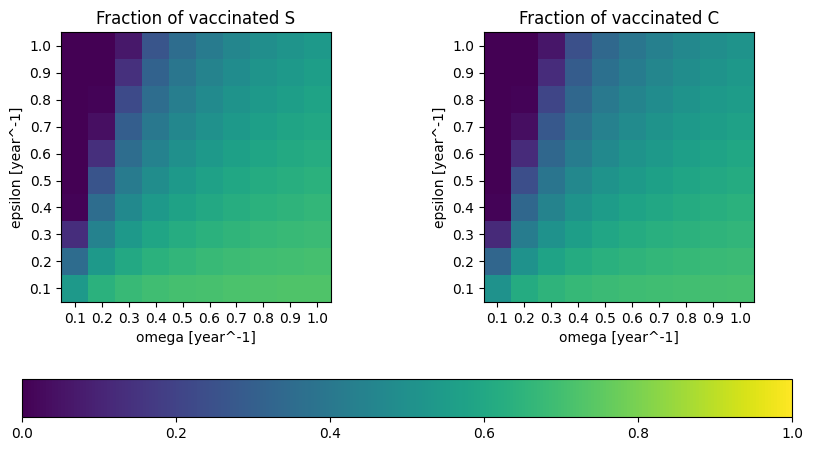

In [133]:
# Plot fraction of vaccinated individuals in S and C classes
nplots = 2
images = []
width = 5
fraction = np.zeros((len(epsilon_list), len(omega_list), nplots))
fig, ax = plt.subplots(1, nplots, figsize=(nplots*width, width))
for i in range(nplots):
    fraction[:,:,i] = equilibrium[:,:,2*i+1] / (equilibrium[:,:,2*i] + equilibrium[:,:,2*i+1])
    images.append(ax[i].imshow(
        fraction[:,:,i],
        cmap='viridis', 
        norm=plt.Normalize(vmin=0,vmax=1),
        # norm=LogNorm(vmin=0.66,vmax=0.7),
        extent=[low_omega-step_omega/2,
                high_omega+step_omega/2,
                low_epsilon-step_epsilon/2,
                high_epsilon+step_epsilon/2],
        origin='lower'
        ))
    ax[i].set_xlabel('omega [year^-1]')
    ax[i].set_ylabel('epsilon [year^-1]')
    ax[i].set_xticks(omega_list * 365)
    ax[i].set_yticks(epsilon_list * 365)
    ax[i].set_title(f'Fraction of vaccinated {compartments[i]}')
cbar = fig.colorbar(images[0], ax=ax, orientation='horizontal', fraction=0.1, pad=0.2)
plt.show()

In [ ]:
# Plot all S and C classes
nplots = 2
images = []
width = 5
fraction = np.zeros((len(epsilon_list), len(omega_list), nplots))
fig, ax = plt.subplots(1, nplots, figsize=(nplots*width, width))
for i in range(nplots):
    fraction[:,:,i] = equilibrium[:,:,2*i+1] / (equilibrium[:,:,2*i] + equilibrium[:,:,2*i+1])
    images.append(ax[i].imshow(
        fraction[:,:,i],
        cmap='viridis', 
        norm=plt.Normalize(vmin=0,vmax=1),
        # norm=LogNorm(vmin=0.66,vmax=0.7),
        extent=[low_omega-step_omega/2,
                high_omega+step_omega/2,
                low_epsilon-step_epsilon/2,
                high_epsilon+step_epsilon/2],
        origin='lower'
        ))
    ax[i].set_xlabel('omega [year^-1]')
    ax[i].set_ylabel('epsilon [year^-1]')
    ax[i].set_xticks(omega_list * 365)
    ax[i].set_yticks(epsilon_list * 365)
    ax[i].set_title(f'Fraction of vaccinated {compartments[i]}')
cbar = fig.colorbar(images[0], ax=ax, orientation='horizontal', fraction=0.1, pad=0.2)
plt.show()

##### d. Modify betaB and betaC, keep epsilon and omega fixed

In [ ]:
low_betaC = 0
high_betaC = 10
step_betaC = 1
points_betaC = round((high_betaC - low_betaC) / step_betaC) + 1

low_gammaC = 0
high_gammaC = 10
step_gammaC = 1
points_gammaC = round((high_gammaC - low_gammaC) / step_gammaC) + 1

nu = 0          # births (and total deaths)
betaB = 0       # contact rate to B
betaC_list = np.linspace(low_betaC, high_betaC, points_betaC)    # contact rate to C
gammaB = 0      # recovery rate from B
gammaC_list = np.linspace(low_gammaC, high_gammaC, points_gammaC)    # recovery rate from C
epsilon = 0.5   # effective vaccination rate (only menC)
omega = 0.5     # vaccine waning rate
kappa = 0.1     # vaccine immunity to menC
a = 1           # ability to tramsit infection by vaccinated and infected individuals (1 = no reduced infection transmission)
m = 0           # proportion of infected who lose carriage after vaccination

print('betaC values: ', betaC_list)
print('gammaC values: ', gammaC_list)

t_init = 0
t_fin = 200

S_init = 0.9
B_init = 0
C_init = 0.1
SV_init = 0
BV_init = 0
CV_init = 0
init_values = [S_init, B_init, C_init, SV_init, BV_init, CV_init]

compartments = ['S', 'C', 'SV', 'CV']
n = len(compartments)
equilibrium = np.zeros((len(betaC_list), len(gammaC_list), n))

for i, (betaC, gammaC) in enumerate(itertools.product(betaC_list, gammaC_list)):
    params = [nu, betaB, betaC, gammaB, gammaC, epsilon, omega, kappa, a, m]
    
    sol = solve_ivp(
        ODE, 
        [t_init,t_fin], 
        init_values, 
        args=[params])
    t = sol.t
    y = sol.y

    S, _, C, SV, _, CV = y
    
    row = i // len(gammaC_list)
    col = i % len(gammaC_list)
    equilibrium[row, col] = np.array([S[-1], C[-1], SV[-1], CV[-1]])

    plt.plot(t, S, label='S', color='blue')
    plt.plot(t, C, label='C', color='green')
    plt.plot(t, SV, label='SV', color='lightblue')
    plt.plot(t, CV, label='CV', color='lightgreen')

custom_lines = [
    Line2D([0], [0], color='blue'),
    Line2D([0], [0], color='green'),
    Line2D([0], [0], color='lightblue'),
    Line2D([0], [0], color='lightgreen'),
]

plt.xlabel('t')
plt.ylim(0,1)
plt.legend(custom_lines, compartments, loc='upper right')
plt.show()

In [ ]:
width = 5
fig, ax = plt.subplots(1, n, figsize=(n*width,width))
images = []
for i in range(n):
    images.append(ax[i].imshow(
        equilibrium[:,:,i],
        cmap='viridis', 
        norm=plt.Normalize(vmin=0,vmax=1), 
        # norm=LogNorm(vmin=1e-5,vmax=1),
        extent=[low_gammaC-step_gammaC/2,
                high_gammaC+step_gammaC/2,
                low_betaC-step_betaC/2,
                high_betaC+step_betaC/2],
        origin='lower',
        aspect=step_gammaC/step_betaC
        ))
    ax[i].set_xlabel('gammaC')
    ax[i].set_ylabel('betaC')
    ax[i].set_xticks(gammaC_list)
    ax[i].set_yticks(betaC_list)
    ax[i].set_title(f'Proportion of {compartments[i]}\n at equilibrium')
cbar = fig.colorbar(images[0], ax=ax, orientation='horizontal', fraction=0.1, pad=0.2)
plt.show()

##### e. Explore initial conditions and whether EE (endemic equilibrium) is always reached

In [ ]:
nu = 0          # births (and total deaths)
betaB = 0       # contact rate to B
betaC = 0.9     # contact rate to C
gammaB = 0      # recovery rate from B
gammaC = 0.3    # recovery rate from C
epsilon = 0.8   # effective vaccination rate (only menC)
omega = 0.5     # vaccine waning rate
kappa = 0.1     # vaccine immunity to menC
a = 1           # ability to tramsit infection by vaccinated and infected individuals (1 = no reduced infection transmission)
m = 0           # proportion of infected who lose carriage after vaccination

params = [nu, betaB, betaC, gammaB, gammaC, epsilon, omega, kappa, a, m]

t_init = 0
t_fin = 200

low_C_init = 0.01
high_C_init = 0.2
step_C_init = 0.01
points_C_init = round((high_C_init - low_C_init) / step_C_init) + 1
C_init_list = np.linspace(low_C_init, high_C_init, points_C_init)

low_CV_init = 0.01
high_CV_init = 0.2
step_CV_init = 0.01
points_CV_init = round((high_CV_init - low_CV_init) / step_CV_init) + 1
CV_init_list = np.linspace(low_CV_init, high_CV_init, points_CV_init)

B_init = 0
BV_init = 0

compartments = ['S', 'C', 'SV', 'CV']
n = len(compartments)
equilibrium = np.zeros((len(C_init_list), len(CV_init_list), n))

for i, (C_init, CV_init) in enumerate(itertools.product(C_init_list, CV_init_list)):
    S_init = np.random.uniform(0,1-C_init-CV_init)
    SV_init = 1 - S_init - C_init - CV_init
    init_values = [S_init, B_init, C_init, SV_init, BV_init, CV_init]

    assert np.allclose(np.sum(init_values), 1)

    sol = solve_ivp(
        ODE, 
        [t_init,t_fin], 
        init_values, 
        args=[params])
    t = sol.t
    y = sol.y

    S, _, C, SV, _, CV = y
    
    row = i // len(CV_init_list)
    col = i % len(CV_init_list)
    equilibrium[row, col] = np.array([S[-1], C[-1], SV[-1], CV[-1]])

    # if C[-1] < 0.01:
        # print(init_values)
    plt.plot(t, S, label='S', color='blue')
    plt.plot(t, C, label='C', color='green')
    plt.plot(t, SV, label='SV', color='lightblue')
    plt.plot(t, CV, label='CV', color='lightgreen')

custom_lines = [
    Line2D([0], [0], color='blue'),
    Line2D([0], [0], color='green'),
    Line2D([0], [0], color='lightblue'),
    Line2D([0], [0], color='lightgreen'),
]

plt.xlabel('t')
plt.ylim(0,1)
plt.legend(custom_lines, compartments, loc='upper right')
plt.show()

##### f. Compare _leaky_ and _all-or-nothing_ vaccine models

### 2. Births and deaths

### 3. Age-structures (with births and without)